In [1]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
import librosa
import os as os
import pandas as pd
import re
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from matplotlib import cm, colors, colorbar
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
rdg = RidgeClassifier(alpha=0.5)
#mlp=MLPClassifier(random_state=1,max_iter=300,activation='relu',solver='sgd',learning_rate='constant',learning_rate_init=0.0001)
mlp=MLPClassifier(random_state=1,max_iter=300,activation='relu')
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression(random_state=1,max_iter=500)
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=0,max_depth=10)
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100, random_state=0)
from sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(n_estimators=100, random_state=1)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
from sklearn.linear_model import SGDClassifier
#SGD=SGDClassifier(loss= 'log',random_state=1,max_iter=100,early_stopping=True,learning_rate='optimal',validation_fraction=0.2)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
mmscaler= MinMaxScaler()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10, random_state=0)
from sklearn.svm import SVC
clf_svm=SVC(kernel='rbf')
linear_svm=SVC(kernel='linear')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.stats.mstats import mquantiles
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.model_selection import LeaveOneOut
pca = PCA(n_components=2, svd_solver='full')
import random
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

2023-11-10 14:16:14.823474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 14:16:17.549782: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 14:16:23.113278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-10 14:16:23.113536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def read_eeg(data):
    with open(data) as f:
        raw = []
        for line in f:
            line = line.split() # to deal with blank 
            if line:            # lines (ie skip them)
                line = [int(float(i)) for i in line]
                raw.append(line)
    df = pd.DataFrame (raw,columns=['Channel_1','Channel_2','Channel_3','Channel_4','Channel_5','Channel_6','Channel_7','Channel_8',
                            'Channel_9','Channel_10','Channel_11','Channel_12','Channel_13','Channel_14','Channel_15'
                             ,'Channel_16','Channel_17','Channel_18','Channel_19'])
    return df

from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def noise_filter(df):
    filt_data=pd.Series()
    for i in range(0, df.shape[1]):
        signal = df.iloc[:,i].values
        data=butter_bandpass_filter(signal,0.1,45,128,3)
        
        filt_data=pd.concat([filt_data,pd.Series(data)],axis=1)
    filt_data=filt_data.iloc[:,1:]
    filt_data.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19']
    return filt_data

In [3]:
total_tps=34944-5*128 # cut all EEG of all subjects into equal length = 34944-5*128=34304 time points
number_of_epochs=26 # segment each subject's EEG into 26 epochs
number_of_tps=1280 # each epoch include 1280 time points

In [4]:
os.chdir("/home/jupy/Raw_data/Time_0/Obese")
ob_0=os.listdir(os.getcwd())
ob_0.remove('.ipynb_checkpoints')
#ob_0.remove('New')

eeg_ob_0=np.zeros([len(ob_0),total_tps,19])
for i in range(0,len(ob_0)):
    eeg_ob_0[i,:,:]=(read_eeg(ob_0[i]).values)[0:total_tps,:]

os.chdir("/home/jupy/Raw_data/Time_0/Lean")
l_0=os.listdir(os.getcwd())
l_0.remove('.ipynb_checkpoints')
#l_0.remove('New')

eeg_l_0=np.zeros([len(l_0),total_tps,19])
for i in range(0,len(l_0)):
    eeg_l_0[i,:,:]=(read_eeg(l_0[i]).values)[0:total_tps,:]
    
X_0=np.vstack([eeg_ob_0,eeg_l_0])
print ('eeg_ob_0',eeg_ob_0.shape)
print ('eeg_l_0',eeg_l_0.shape)
print('X_0',X_0.shape)

eeg_ob_0 (30, 34304, 19)
eeg_l_0 (30, 34304, 19)
X_0 (60, 34304, 19)


In [5]:
y=[0]*30+[1]*30

X_0_clean=np.zeros([60, 34304, 19])
for i in range(0,X_0.shape[0]):
    X_0_clean[i,:,:]=noise_filter(pd.DataFrame(X_0[i,:,:]))
X_0_clean=X_0_clean[:,0:int(number_of_epochs*number_of_tps),:]

X2_0=np.zeros([number_of_epochs*X_0_clean.shape[0],int(number_of_tps),19])
for chan in range(0,19):
    X1=np.zeros([number_of_epochs*X_0_clean.shape[0],int(number_of_tps)])
    for subj in range(0,X_0_clean.shape[0]):
        X1[subj*number_of_epochs:(subj+1)*number_of_epochs,:]=X_0_clean[subj,0:int(number_of_epochs*number_of_tps),chan].reshape(int(number_of_epochs),int(number_of_tps))
    X2_0[:,:,chan]=X1

/tmp/ipykernel_49807/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_49807/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_49807/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_49807/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_49807/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' ins

In [6]:
XX_0=np.zeros([X2_0.shape[0],19,number_of_tps])
for i in range(0,X2_0.shape[0]):
    XX_0[i,:,:]=X2_0[i,:,:].transpose()
print(XX_0.shape)

(1560, 19, 1280)


In [7]:
Y2=[]
for n in y:
    Y2=Y2+[n]*number_of_epochs
len(Y2)

1560

In [8]:
del eeg_l_0
del eeg_ob_0
del X_0
del X_0_clean
del X2_0

In [9]:
y_test_short=[1,1,1,0,0,0]

def subj_class_prob(result):
    pred=[]
    for i in range(0,6):
        #print(np.where(np.array(result[i*number_of_epochs:(i+1)*number_of_epochs])==1)[0].shape[0]/number_of_epochs)
        print(sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[0], sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[1])
        if sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[0]>sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[1]:
            pred.append(0)
        else:
            pred.append(1)
    return pred

# VAE

In [10]:
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout,Add,LSTM,Reshape,Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,AveragePooling1D,GlobalAveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Conv1D,Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Conv1D,Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.preprocessing import minmax_scale

# feature extraction

In [11]:
os.chdir('/home/jupy/SavedModel/autoencoder/T0_to_T0')
#os.chdir('/home/jupy/SavedModel/autoencoder/T15_to_T15')
mm_feature_output_0_0={}
for n in range(0,60):#2-48
    xar_0=XX_0[n*26:(n+1)*26,:,:]
    xar_norm_0=np.zeros([xar_0.shape[0],xar_0.shape[1],xar_0.shape[2]])
    for i in range(0,xar_0.shape[0]):
        for j in range(0,xar_0.shape[1]):
            xar_norm_0[i,j,:]=minmax_scale(xar_0[i,j,:])
    xar_0=xar_norm_0
    xar_0=np.expand_dims(xar_0,axis=-1)
    mm=load_model(f'T0_to_T0_VAE{n}')

    intermediate_layer_model = Model(inputs=mm.input,outputs=mm.get_layer('spatial_conv').output)
    #intermediate_layer_model.compile(optimizer=Adam(learning_rate=0.001))
    mm_feature_output_0_0[n]= intermediate_layer_model.predict(xar_0)
    
adapt_auto_feat_0_0=np.zeros([26*60,1,1217,8])
for n in range(0,60):
    adapt_auto_feat_0_0[n*26:(n+1)*26,:,:,:]=mm_feature_output_0_0[n]
Adapt_feat_0_0=np.zeros([26*60,1217*8])
for i in range(0,adapt_auto_feat_0_0.shape[0]):
    Adapt_feat_0_0[i,:]=adapt_auto_feat_0_0[i,:,:,:].flatten()

2023-11-10 16:15:42.743594: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-10 16:15:42.743659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (panata): /proc/driver/nvidia/version does not exist
2023-11-10 16:15:42.759168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 44ms/step


In [12]:
Adapt_feat_0_0.shape

(1560, 9736)

In [34]:
raw_0=np.zeros([XX_0.shape[0],(XX_0.shape[1]*XX_0.shape[2])])
for i in range(0,1560):
    raw_0[i,:]=XX_0[i,:,:].flatten()

### Convex Hull


# Genetic Algorithm

0-125: good qulaity
126-220:middle quality
220-:bad quality

In [200]:
subj_y=[]
for i in range(0,int(Adapt_feat_0_0.shape[0]/26)):
     subj_y.append([i]*26)
subj_y=np.array(subj_y).flatten()
subj_y.shape

(1560,)

In [297]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


n_estimators = 200
rf = RandomForestClassifier(n_estimators=n_estimators, bootstrap=True)
X_train, X_test, y_train, y_test = train_test_split(Adapt_feat_0_0, quality_y, test_size=0.2, random_state=42,stratify=quality_y
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

rf.feature_importances_
feat_id=rf.feature_importances_.argsort()[-500:][::-1]

Accuracy: 0.7307692307692307


# clustering

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2) 
ardata=Adapt_feat_0_0
tsardata=tsne.fit_transform(ardata)

/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


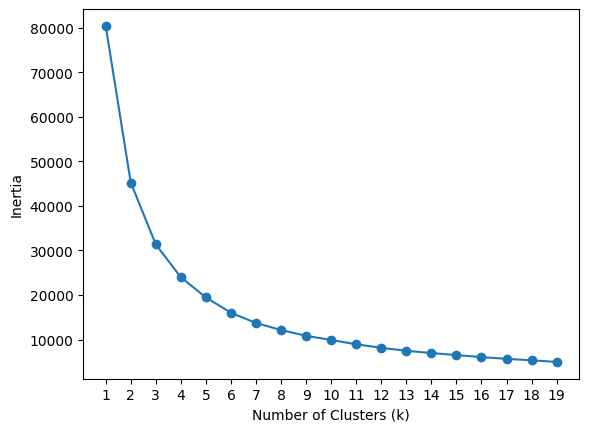

In [23]:
inertia = []
for k in range(1, 20):  # You can adjust the range of k as needed
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tsardata)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 20))
#plt.title('Elbow for Optimal k')
plt.show()

In [17]:
from sklearn.cluster import KMeans
n_clusters = 5 # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(ardata)
cluster_assignments = kmeans.labels_

In [18]:
cluster_assignments.shape
cluster_purity=[]
for i in range(0,60):
    cluster_count=(np.unique(cluster_assignments[i*26:(i+1)*26], return_counts=True)[0].shape[0])
    #print(np.unique(cluster_assignments[i*26:(i+1)*26], return_counts=True)[0].shape[0])
    cluster_purity.append(cluster_count)

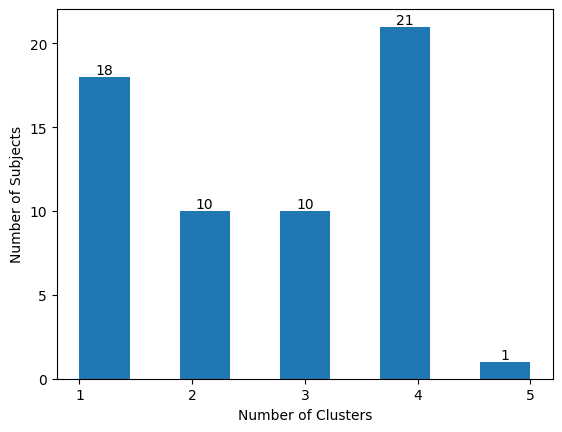

In [33]:
counts, bins, _ = plt.hist(cluster_purity, bins=9)
for count, x in zip(counts, bins):
    if count > 0:  # Remove 0 count
        plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Number of Clusters')
plt.ylabel('Number of Subjects')
plt.xticks(range(1, 6))  # Set the x-axis to start from 1 to 9
plt.yticks(range(0, 23, 5))  # Set the y-axis range from 0 to 22 with intervals of 5

plt.show()


In [35]:

good_q_id=np.where(np.array(cluster_purity)<=2)[0]
midhigh_q_id = np.where((2 < np.array(cluster_purity)) & (np.array(cluster_purity) <=3))[0]
midlow_q_id = np.where((3< np.array(cluster_purity)) & (np.array(cluster_purity) <= 3.5))[0]
bad_q_id = np.where(np.array(cluster_purity)>3.5)[0]

print('good subj',good_q_id)
print('midhigh subj',midhigh_q_id)
print('midlow subj',midlow_q_id)
print('bad subj',bad_q_id)

quality_y=np.empty([1560,])
#quality_ar=np.zeros[1560,9736]
for i in good_q_id:
    #print(np.arange(i*26,(i+1)*26))
    quality_y[np.arange(i*26,(i+1)*26)]=0
    
for j in midhigh_q_id:
    quality_y[np.arange(j*26,(j+1)*26)]=1
    
for r in midlow_q_id:
    quality_y[np.arange(r*26,(r+1)*26)]=1
    
for z in bad_q_id:
    quality_y[np.arange(z*26,(z+1)*26)]=2

good subj [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 34]
midhigh subj [27 28 30 47 53 54 56 57 58 59]
midlow subj []
bad subj [29 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 48 49 50 51 52 55]


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Number of trees in the Random Forest
n_estimators = 200

# Create a Random Forest classifier with bootstrapping
rf = RandomForestClassifier(n_estimators=n_estimators, bootstrap=True)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Adapt_feat_0_0, quality_y, test_size=0.2, random_state=42,stratify=quality_y
)#, 
# Train the Random Forest model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8397435897435898


In [37]:
rf.feature_importances_
feat_id=rf.feature_importances_.argsort()[-500:][::-1]

# train/test split

Insert a token as subeject ID


In [398]:
s_range=range(0,10)

In [417]:
data_ind=[]
for n in range(0,10):
    data_ind.append(np.array([30,31,32,0,1,2])+n*3)

Xtest_id={}
Xtv_id={}


for s in s_range:    
    Xtest_id[s]=data_ind[s]
    #Xtv_id[s]=flatten(data_ind[0:s]+data_ind[(s+1):])
    Xtv_id[s]=(np.array(data_ind[0:s]).flatten().tolist())+(np.array(data_ind[(s+1):]).flatten().tolist())
    print('set',s,Xtest_id[s])
    print('set',s,Xtv_id[s])
    print('----------------------------')
    
Xdata= #raw_0#Adapt_feat_0_0#[:,feat_id]
Ydata=np.array(Y2)#quality_y#
Xtv={}
Ytv={}
Xtest={}
Ytest={}
for s in s_range:
    print('set',s)
    Xtest[s]=np.zeros([Xdata.shape[0],Xdata.shape[1]])
    Ytest[s]=np.zeros([Xdata.shape[0],])
    print('test_id',Xtest_id[s])
    for test_id in Xtest_id[s]:
            Xtest[s]=np.vstack([Xtest[s],Xdata[test_id*number_of_epochs:(test_id+1)*number_of_epochs,:]])
            Ytest[s]=np.hstack([Ytest[s],Ydata[test_id*number_of_epochs:(test_id+1)*number_of_epochs,]])
          
    Xtest[s]=Xtest[s][Xdata.shape[0]:,:] 
    Ytest[s]=Ytest[s][Xdata.shape[0]:,] 
    
    Xtv[s]=np.zeros([Xdata.shape[0],Xdata.shape[1]])
    Ytv[s]=np.zeros([Xdata.shape[0],])
    print('tv_id',Xtv_id[s])
    for tv_id in Xtv_id[s]:
            Xtv[s]=np.vstack([Xtv[s],Xdata[tv_id*number_of_epochs:(tv_id+1)*number_of_epochs,:]])
            Ytv[s]=np.hstack([Ytv[s],Ydata[tv_id*number_of_epochs:(tv_id+1)*number_of_epochs,]])
            
    Xtv[s]=Xtv[s][Xdata.shape[0]:,:] 
    Ytv[s]=Ytv[s][Xdata.shape[0]:,] 

set 0 [30 31 32  0  1  2]
set 0 [33, 34, 35, 3, 4, 5, 36, 37, 38, 6, 7, 8, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 1 [33 34 35  3  4  5]
set 1 [30, 31, 32, 0, 1, 2, 36, 37, 38, 6, 7, 8, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 2 [36 37 38  6  7  8]
set 2 [30, 31, 32, 0, 1, 2, 33, 34, 35, 3, 4, 5, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 3 [39 40 41  9 10 11]
set 3 [30, 31, 32, 0, 1, 2, 33, 34, 35, 3, 4, 5, 36, 37, 38, 6, 7, 8, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22,

In [418]:
print(Xtv[s].shape, Ytv[s].shape)

(1404, 24320) (1404,)


In [419]:
all_id_long={}
X_all_shuffled={}
Y_all_shuffled={}
Y_all_shuffled_cat={}
for s in s_range:
    np.random.seed(2)
    all_id_long[s]=np.arange(0,Xtv[s].shape[0])
    np.random.shuffle(all_id_long[s])
    
    X_all_shuffled[s]=np.zeros([ Xtv[s].shape[0], Xtv[s].shape[1]])
    Y_all_shuffled[s]=np.zeros([ Xtv[s].shape[0]])
    for n in range(0,all_id_long[s].shape[0]):
        X_all_shuffled[s][n,:]=Xtv[s][all_id_long[s][n],:]
        #print(n,all_id_long[s][n])
        Y_all_shuffled[s][n]=Ytv[s][all_id_long[s][n]]
    print(X_all_shuffled[s].shape)
    print(Y_all_shuffled[s].shape)

(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)
(1404, 24320)
(1404,)


accuracy of subject filtered feautres vae

In [412]:
scores=[]
for s in s_range:
    knn.fit(X_all_shuffled[s],Y_all_shuffled[s])
    print(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
    scores.append(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
print('avg',sum(scores)/len(scores))

0.5897435897435898
0.7884615384615384
0.8397435897435898
0.9615384615384616
0.9935897435897436
0.9935897435897436
0.9935897435897436
1.0
0.9743589743589743
0.9615384615384616
avg 0.9096153846153847


accuracy of vae as features

In [416]:
scores=[]
for s in s_range:
    knn.fit(X_all_shuffled[s],Y_all_shuffled[s])
    print(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
    scores.append(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
print('avg',sum(scores)/len(scores))

0.5256410256410257
0.5384615384615384
0.5064102564102564
0.6153846153846154
0.5512820512820513
0.7243589743589743
0.9102564102564102
0.8846153846153846
0.8141025641025641
0.8782051282051282
avg 0.6948717948717948


accuracy of raw eeg as features

In [420]:
scores=[]
for s in s_range:
    knn.fit(X_all_shuffled[s],Y_all_shuffled[s])
    print(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
    scores.append(accuracy_score(knn.predict(Xtest[s]),Ytest[s]))
print('avg',sum(scores)/len(scores))

0.46794871794871795
0.5512820512820513
0.5705128205128205
0.47435897435897434
0.532051282051282
0.46794871794871795
0.5384615384615384
0.5448717948717948
0.5256410256410257
0.5
avg 0.5173076923076922


# 1D CNN

In [313]:
def OneD_EEGNet(nb_classes=2,dropoutRate = 0.25,norm_rate = 0.25, dropoutType = 'Dropout'):

        input1   = Input(shape = (9736, 1))

        ##################################################################
        block1       = Conv1D(8, (64))(input1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = Conv1D(16, (32))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = AveragePooling1D((4))(block1)
        block1       = Dropout(dropoutRate)(block1)

        block2       = Conv1D(32, (16))(block1)
        block2       = BatchNormalization()(block2)
        block2       = Activation('relu')(block2)

        block2       = AveragePooling1D((8))(block2)
        #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
        block2       = Dropout(dropoutRate)(block2)

        flatten      = Flatten(name = 'flatten')(block2)
        initializer = initializer = tf.keras.initializers.Identity()
        dense        = Dense(nb_classes, name = 'dense', 
                             kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
        softmax      = Activation('softmax', name = 'softmax')(dense)

        return Model(inputs=input1, outputs=softmax)   

In [314]:
 for s in range(1,2):
        
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005
    
    model=OneD_EEGNet()
    model.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=model.fit( X_all_shuffled[s].reshape(1404, 9736,1),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 

Epoch 1/100
12/12 [==============================] - 12s 891ms/step - loss: 0.2187 - accuracy: 0.8744 - val_loss: 11.0239 - val_accuracy: 0.4413
Epoch 2/100
12/12 [==============================] - 11s 884ms/step - loss: 0.0501 - accuracy: 0.9804 - val_loss: 12.0168 - val_accuracy: 0.4520
Epoch 3/100
12/12 [==============================] - 11s 884ms/step - loss: 0.0198 - accuracy: 0.9920 - val_loss: 7.5713 - val_accuracy: 0.5089
Epoch 4/100
12/12 [==============================] - 11s 878ms/step - loss: 0.0161 - accuracy: 0.9947 - val_loss: 4.1291 - val_accuracy: 0.5907
Epoch 5/100
12/12 [==============================] - 11s 882ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 3.5077 - val_accuracy: 0.5872
Epoch 6/100
12/12 [==============================] - 11s 887ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 2.5231 - val_accuracy: 0.6370
Epoch 7/100
12/12 [==============================] - 11s 885ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 1.0738 - val_accurac

KeyboardInterrupt: 

In [304]:
best_weights = model.get_weights()
model.set_weights(best_weights)

In [118]:
quality_model=model

In [153]:
#model.summary()

In [315]:
#os.chdir('/home/jupy/SavedModel/autoencoder/T0_to_T0/classifier')
for s in range(1,2):
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=model
    result=[]
    predicted=classifier.predict(Xtest[s])
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 0s 26ms/step
ep score 0.9935897435897436
0.015912706 25.984089
0.9839079 25.01609
0.00077264634 25.999228
25.99489 0.005109649
25.999779 0.00021897478
25.998386 0.0016118996
score 1.0


In [45]:
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2, perplexity=15)
tsne_feat=tsne.fit_transform(Adapt_feat_0_0[:,feat_id])
tsne_vae=tsne.fit_transform(Adapt_feat_0_0)
tsne_org=tsne.fit_transform(raw_0)

/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnin

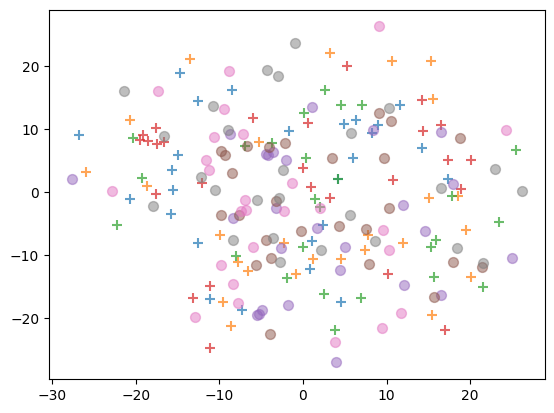

In [87]:

for i in [0, 10, 20, 29, 31, 40, 48, 59]:
    if i < 30:
        plt.scatter(
            tsne_org[i * 26:(i + 1) * 26, 0],
            tsne_org[i * 26:(i + 1) * 26, 1],
            alpha=0.7, marker='+',
            s=50, label='Lean')
    else:
        plt.scatter(
            tsne_org[i * 26:(i + 1) * 26, 0],
            tsne_org[i * 26:(i + 1) * 26, 1],
            alpha=0.5, marker='o',
            s=50, label='Obese')

#plt.legend(['Lean', 'Obese'])
plt.show()


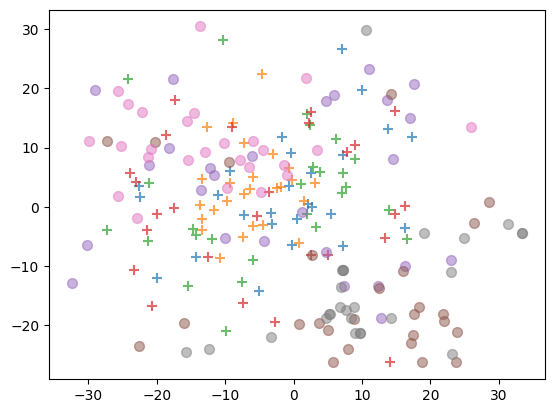

In [86]:
for i in [8, 4, 12, 24, 41, 49, 34, 50]:
    if i < 30:
        plt.scatter(
            tsne_vae[i * 26:(i + 1) * 26, 0],
            tsne_vae[i * 26:(i + 1) * 26, 1],
            alpha=0.7, marker='+',
            s=50, label='Lean')
    else:
        plt.scatter(
            tsne_vae[i * 26:(i + 1) * 26, 0],
            tsne_vae[i * 26:(i + 1) * 26, 1],
            alpha=0.5, marker='o',
            s=50, label='Obese')

#plt.legend(['Lean', 'Obese'])
plt.show()

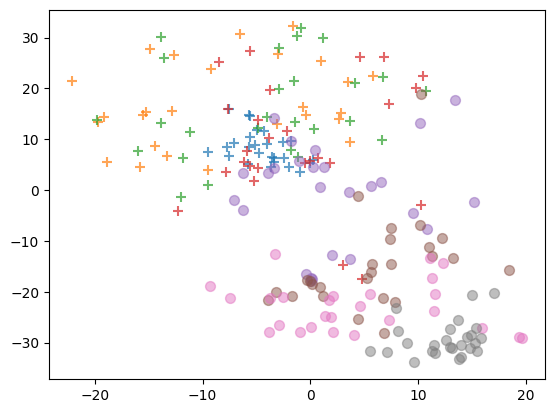

In [85]:


for i in [0, 10, 20, 29, 31, 40, 48, 59]:
    if i < 30:
        plt.scatter(
            tsne_feat[i * 26:(i + 1) * 26, 0],
            tsne_feat[i * 26:(i + 1) * 26, 1],
            alpha=0.7, marker='+',
            s=50, label='Lean')
    else:
        plt.scatter(
            tsne_feat[i * 26:(i + 1) * 26, 0],
            tsne_feat[i * 26:(i + 1) * 26, 1],
            alpha=0.5, marker='o',
            s=50, label='Obese')


# robust_feature_outputs.shape

In [165]:
def OneD_EEGNet(nb_classes=2,dropoutRate = 0.25,norm_rate = 0.25, dropoutType = 'Dropout'):

        input1   = Input(shape = (9568, 1))

        ##################################################################
        block1       = Conv1D(8, (64))(input1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = Conv1D(16, (32))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = AveragePooling1D((4))(block1)
        block1       = Dropout(dropoutRate)(block1)

        block2       = Conv1D(32, (16))(block1)
        block2       = BatchNormalization()(block2)
        block2       = Activation('relu')(block2)

        block2       = AveragePooling1D((8))(block2)
        #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
        block2       = Dropout(dropoutRate)(block2)

        flatten      = Flatten(name = 'flatten')(block2)
        initializer = initializer = tf.keras.initializers.Identity()
        dense        = Dense(nb_classes, name = 'dense', 
                             kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
        softmax      = Activation('softmax', name = 'softmax')(dense)

        return Model(inputs=input1, outputs=softmax)   

In [168]:
 for s in range(1,2):
        
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.0001)#learning_rate=0.0005
    
    model=OneD_EEGNet()
    model.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=model.fit( robust_feature_outputs.reshape(1404, 9568,1),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1) 

Epoch 1/100
12/12 [==============================] - 11s 879ms/step - loss: 0.6920 - accuracy: 0.5298 - val_loss: 0.6905 - val_accuracy: 0.5658
Epoch 2/100
12/12 [==============================] - 11s 873ms/step - loss: 0.6310 - accuracy: 0.7079 - val_loss: 0.6859 - val_accuracy: 0.7260
Epoch 3/100
12/12 [==============================] - 11s 874ms/step - loss: 0.5254 - accuracy: 0.8344 - val_loss: 0.6757 - val_accuracy: 0.5836
Epoch 4/100
12/12 [==============================] - 11s 876ms/step - loss: 0.4028 - accuracy: 0.8744 - val_loss: 0.6761 - val_accuracy: 0.4591
Epoch 5/100
12/12 [==============================] - 11s 876ms/step - loss: 0.2951 - accuracy: 0.9074 - val_loss: 0.7200 - val_accuracy: 0.4484
Epoch 6/100
12/12 [==============================] - 10s 872ms/step - loss: 0.2341 - accuracy: 0.9288 - val_loss: 0.8366 - val_accuracy: 0.4448
Epoch 7/100
12/12 [==============================] - 10s 870ms/step - loss: 0.1924 - accuracy: 0.9412 - val_loss: 0.9468 - val_accuracy:

In [169]:
best_weights = model.get_weights()
model.set_weights(best_weights)

In [170]:
#robust_layer_model = Model(inputs=quality_model.input,outputs=quality_model.get_layer('average_pooling1d_1').output)
robust_feature_output_test= robust_layer_model.predict( Xtest[s])


robust_feature_outputs_test=np.zeros([Xtest[s].shape[0],int(299*32)])
for i in range(0,Xtest[s].shape[0]):
    robust_feature_outputs_test[i*26:(i+1)*26,:]=robust_feature_output_test[i,:,:].flatten()

5/5 [==============================] - 0s 26ms/step


In [175]:
robust_feature_outputs_test.shape

(156, 9568)

In [174]:
#model.summary()
Xtest[s].shape

(156, 9736)

In [176]:
for s in range(1,2):
    #classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    classifier=model
    result=[]
    predicted=classifier.predict(robust_feature_outputs_test)
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

5/5 [==============================] - 0s 25ms/step
ep score 0.5
11.384966 14.615033
11.857745 14.142255
11.915186 14.084812
11.391049 14.608952
11.599937 14.400062
11.50978 14.490218
score 0.5
